<h2 style="font-size:24px;">Load Packages</h2>

In [1]:
import pandas as pd
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import resize
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch import optim
from RdmDataset import RdmDataset
from RdmClassifier import RdmClassifier
from RdmFullCapture import RdmFullCapture
from datetime import datetime


<h2 style="font-size:24px;"> Create Train and Validation Datasets </h2>

In [2]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v2.csv"

root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_1Ch'

all_folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])

num_train_folders = int(len(all_folders) * 0.7)
num_val_folders = int(len(all_folders) * 0.15)

# # Remaining folders will be for testing

# train_folders = all_folders[:num_train_folders]
# val_folders = all_folders[num_train_folders:num_train_folders + num_val_folders]

# # Data loader setup
# def setup_train_val_loaders(root_dir, event_csv, folders):
#     datasets = {x: RdmDataset(root_dir, event_csv, folders[x], window_size=100) for x in ['train', 'val']}
#     loaders = {x: DataLoader(datasets[x], batch_size=2, shuffle=True if x == 'train' else False, collate_fn=RdmDataset.collate_fn) for x in datasets}
#     return loaders

# folders = {
#     'train': train_folders,
#     'val': val_folders
# }
# loaders = setup_train_val_loaders(root_dir, event_csv_path, folders)
# train_loader, val_loader= loaders['train'], loaders['val']

Check Datasets

In [3]:
# print(f"Number of training samples: {len(train_loader)}")
# print(f"Number of val samples: {len(val_loader)}")

# data, labels, length, metadata = next(iter(train_loader))
# print(data.shape, labels.shape, length, metadata)

<h2 style="font-size:24px;"> Initialize the model </h2>

In [4]:
# Initialize the model
num_classes = 3  # GOUP, BLNC, DOWN
hidden_size = 128
model = RdmClassifier(num_classes=num_classes, hidden_size=hidden_size)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


<h2 style="font-size:24px;"> Training </h2>

Training and Validation Function

In [5]:
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()  # Training mode
        train_loss = 0
        for data, labels, lengths, metadata in train_loader:
            optimizer.zero_grad()
            data = data.float()  # Ensure data is float
            outputs = model(data, lengths)
            outputs_flat = outputs.view(-1, model.num_classes)
            labels_flat = labels.view(-1)
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)

        # Validation phase
        model.eval()  # Evaluation mode
        val_loss = 0
        with torch.no_grad():
            for data, labels, lengths, metadata in val_loader:
                data = data.float()
                outputs = model(data, lengths)
                outputs_flat = outputs.view(-1, model.num_classes)
                labels_flat = labels.view(-1)
                loss = criterion(outputs_flat, labels_flat)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Train and Validate the Model, then Save the Model

In [6]:
# train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# model_path = f'/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/full_model_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'

# # Saving the entire model (architecture + weights)
# torch.save(model, model_path)

Load the Model

In [7]:
model_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/full_model_2024-03-07 12:29:48.774564.pth'

model_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/models/full_model_2024-03-11_11-38-05.pth'

# Load the entire model
model = torch.load(model_path)

# Set the model to evaluation mode if you're doing inference
model.eval()

RdmClassifier(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): LSTM(1056, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

<h2 style="font-size:24px;"> Testing </h2>

Test Data Loading

72
torch.Size([1, 1000, 23, 13]) torch.Size([1, 1000]) tensor([1000]) ({'channel_number': '1', 'frame_range': (195, 806), 'MOCAP_time_range': (195, 30.72), 'seconds_per_frame': 0.03776, 'RADAR_capture': '18_MNTRL_RR_V1', 'GOUP_ranges': [(268, 280), (475, 487), (684, 697)], 'DOWN_ranges': [(366, 376), (579, 588)], 'window_start_frame': 0, 'window_end_frame': 0},)


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:487: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequences_padded = pad_sequence([torch.tensor(seq, dtype=torch.float) for seq in sequences], batch_first=True)


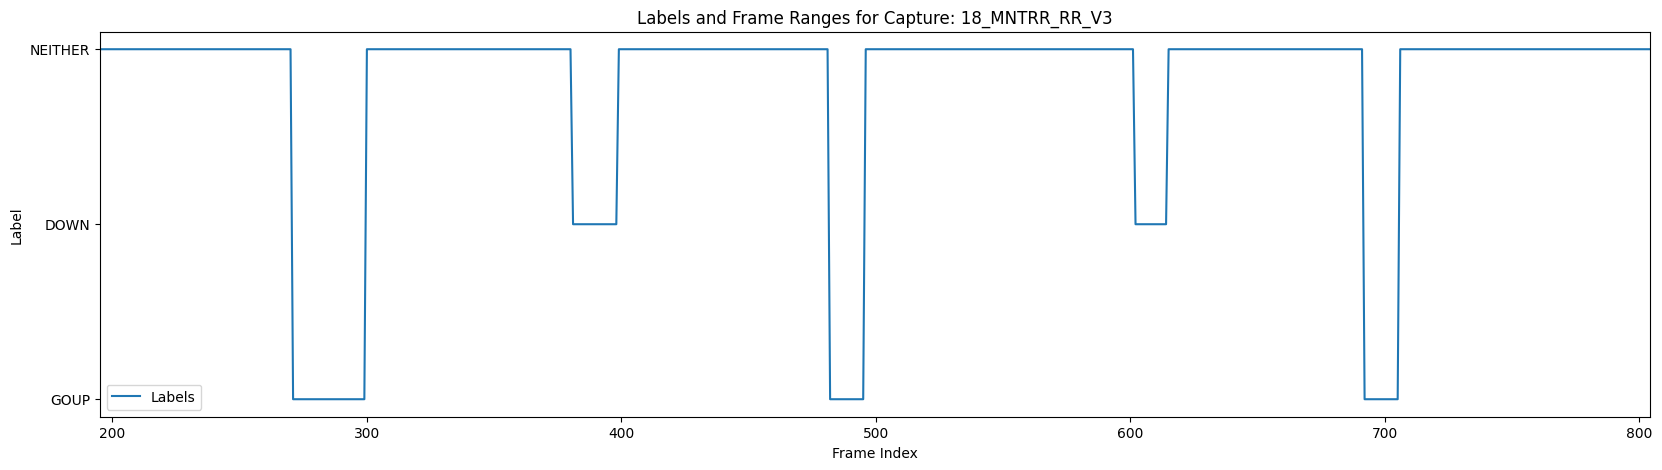

In [8]:
event_csv_path = "/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v3.csv"

root_dir = '/Volumes/FourTBLaCie/Yoga_Study_RADAR_1Ch'

test_folders = all_folders[num_train_folders + num_val_folders:]
#TODO Load files

# Data loader test setup
test_dataset = RdmFullCapture(root_dir, event_csv_path, test_folders, window_size=100)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle= False, collate_fn=test_dataset.collate_fn)

print(len(test_loader))

data, labels, length, metadata = next(iter(test_loader))
print(data.shape, labels.shape, length, metadata)

# Assuming 'rdm_full_capture_dataset' is an instance of RdmFullCapture
test_dataset.plot_labels_and_ranges(20)  # Plot the first capture in the dataset

#TODO Label correctly
#TODO Get Meta Data


In [9]:
# print(windows_tensor.shape)
# print(labels_tensor.shape)
# print(lengths_tensor.shape)
# print(metadata[0])

In [10]:
#Test creating windows for a single capture
windows, labels, lengths, metadata, windows_ranges = test_dataset.create_windows_for_capture(index=0, overlap=90)
print(len(windows))
print(f'individual window shape is {windows[0].shape}')
print(labels.shape)
print(lengths.shape)
print(metadata)
# print(windows_ranges)

Creating windows 52 windows for Radar Capture: 18_MNTRL_RR_V1, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]


52
individual window shape is torch.Size([100, 23, 13])
torch.Size([52, 100])
torch.Size([52])
{'channel_number': '1', 'frame_range': (195, 806), 'MOCAP_time_range': (195, 30.72), 'seconds_per_frame': 0.03776, 'RADAR_capture': '18_MNTRL_RR_V1', 'GOUP_ranges': [(268, 280), (475, 487), (684, 697)], 'DOWN_ranges': [(366, 376), (579, 588)], 'window_start_frame': 0, 'window_end_frame': 0}


72
Creating windows 52 windows for Radar Capture: 18_MNTRL_RR_V1, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windows_tensor = torch.tensor(windows_tensor, dtype=torch.float)


[(268, 0), (366, 1), (475, 0), (579, 1), (684, 0)]
[[3 0 0]
 [0 1 1]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRL_RR_V1, channel: 2
[(268, 0), (366, 1), (475, 0), (579, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [1 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRL_RR_V1, channel: 3
[(268, 0), (366, 1), (475, 0), (579, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRL_RR_V1, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(268, 0), (366, 1), (475, 0), (579, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [1 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V2, channel: 1
[(272, 0), (382, 1), (489, 0), (592, 1), (701, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V2, channel: 2
[(272, 0), (382, 1), (489, 0), (592, 1), (701, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V2, channel: 3


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(272, 0), (382, 1), (489, 0), (592, 1), (701, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V2, channel: 4
[(272, 0), (382, 1), (489, 0), (592, 1), (701, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V3, channel: 1
[(279, 0), (376, 1), (481, 0), (588, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windows_tensor = torch.tensor(windows_tensor, dtype=torch.float)


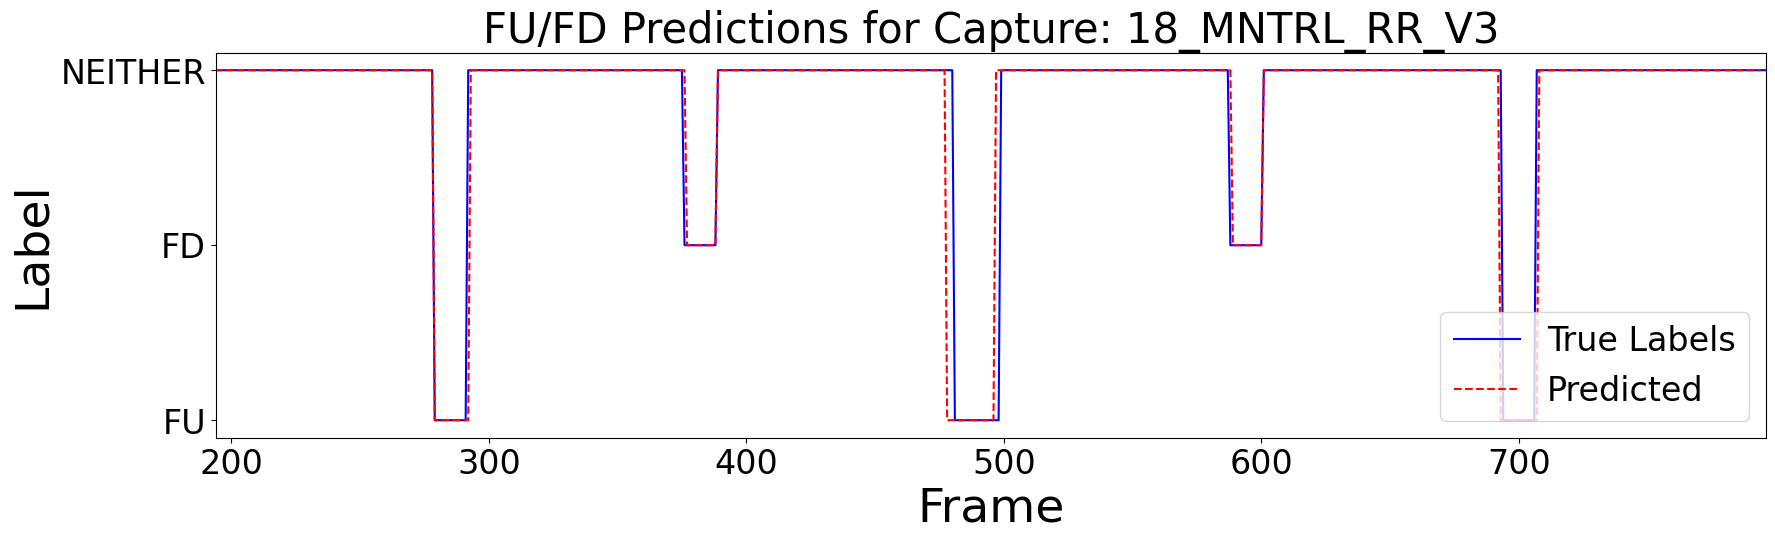

Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V3, channel: 2
[(279, 0), (376, 1), (481, 0), (588, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

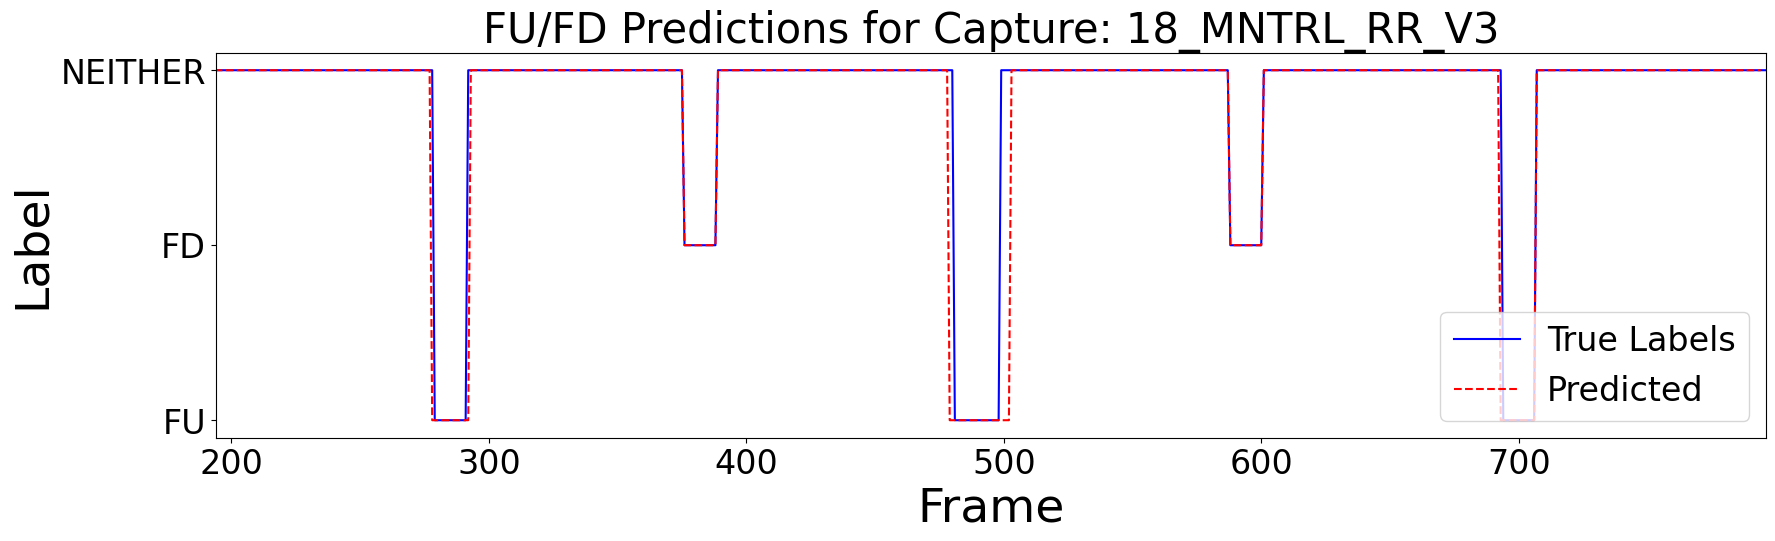

Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V3, channel: 3
[(279, 0), (376, 1), (481, 0), (588, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

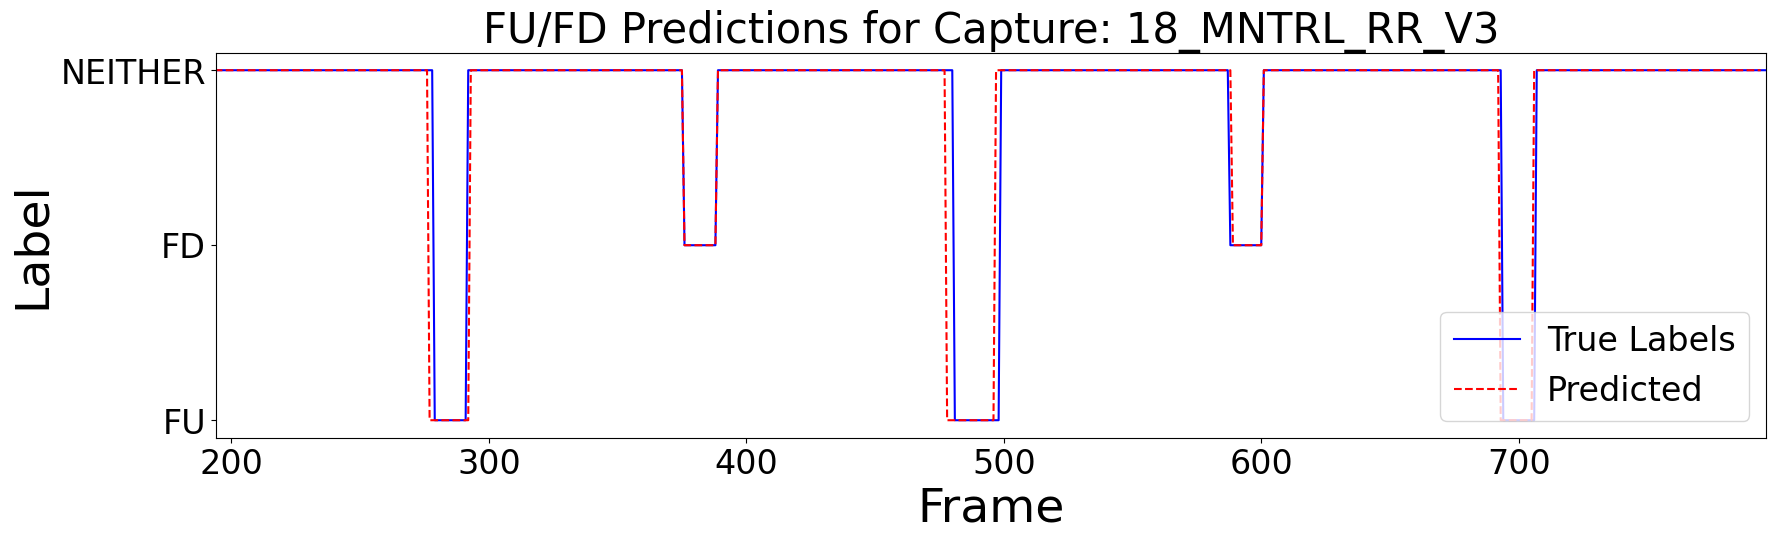

Creating windows 51 windows for Radar Capture: 18_MNTRL_RR_V3, channel: 4
[(279, 0), (376, 1), (481, 0), (588, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

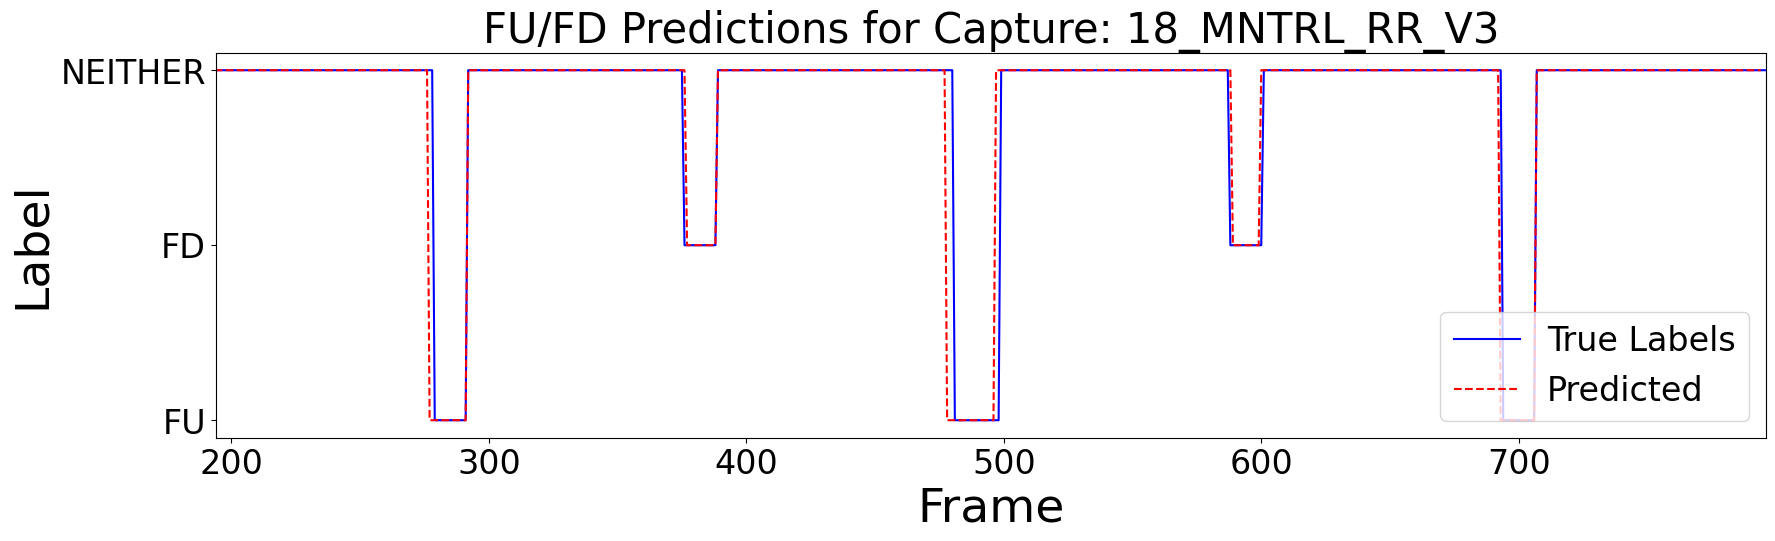

Creating windows 49 windows for Radar Capture: 18_MNTRR_RR_V1, channel: 1
[(269, 0), (380, 1), (476, 0), (583, 1), (691, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 49 windows for Radar Capture: 18_MNTRR_RR_V1, channel: 2


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(269, 0), (380, 1), (476, 0), (583, 1), (691, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 49 windows for Radar Capture: 18_MNTRR_RR_V1, channel: 3
[(269, 0), (380, 1), (476, 0), (583, 1), (691, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 49 windows for Radar Capture: 18_MNTRR_RR_V1, channel: 4
[(269, 0), (380, 1), (476, 0), (583, 1), (691, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRR_RR_V2, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(269, 0), (386, 1), (485, 0), (590, 1), (696, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRR_RR_V2, channel: 2
[(269, 0), (386, 1), (485, 0), (590, 1), (696, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRR_RR_V2, channel: 3
[(269, 0), (386, 1), (485, 0), (590, 1), (696, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 18_MNTRR_RR_V2, channel: 4
[(269, 0), (386, 1), (485, 0), (590, 1), (696, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRR_RR_V3, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(271, 0), (381, 1), (482, 0), (602, 1), (692, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRR_RR_V3, channel: 2
[(271, 0), (381, 1), (482, 0), (602, 1), (692, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRR_RR_V3, channel: 3
[(271, 0), (381, 1), (482, 0), (602, 1), (692, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 18_MNTRR_RR_V3, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(271, 0), (381, 1), (482, 0), (602, 1), (692, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V1, channel: 1
[(263, 0), (305, 1), (483, 0), (589, 1)]
[[2 0 0]
 [0 2 0]
 [1 1 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V1, channel: 2


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(263, 0), (305, 1), (483, 0), (589, 1)]
[[2 0 0]
 [0 2 0]
 [1 1 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V1, channel: 3
[(263, 0), (305, 1), (483, 0), (589, 1)]
[[2 0 0]
 [0 2 0]
 [1 1 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V1, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windows_tensor = torch.tensor(windows_tensor, dtype=torch.float)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

[(263, 0), (305, 1), (483, 0), (589, 1)]
[[2 0 0]
 [0 2 0]
 [1 1 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRL_RR_V2, channel: 1
[(268, 0), (375, 1), (473, 0), (583, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRL_RR_V2, channel: 2
[(268, 0), (375, 1), (473, 0), (583, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRL_RR_V2, channel: 3


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(268, 0), (375, 1), (473, 0), (583, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRL_RR_V2, channel: 4
[(268, 0), (375, 1), (473, 0), (583, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V3, channel: 1
[(272, 0), (374, 1), (483, 0), (584, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V3, channel: 2


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(272, 0), (374, 1), (483, 0), (584, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V3, channel: 3
[(272, 0), (374, 1), (483, 0), (584, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRL_RR_V3, channel: 4
[(272, 0), (374, 1), (483, 0), (584, 1), (694, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRR_RR_V1, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  windows_tensor = torch.tensor(windows_tensor, dtype=torch.float)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sou

[(260, 0), (328, 1), (475, 0), (584, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRR_RR_V1, channel: 2
[(260, 0), (328, 1), (475, 0), (584, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRR_RR_V1, channel: 3
[(260, 0), (328, 1), (475, 0), (584, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 22_MNTRR_RR_V1, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(260, 0), (328, 1), (475, 0), (584, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 55 windows for Radar Capture: 22_MNTRR_RR_V2, channel: 1
[(260, 0), (369, 1), (474, 0), (581, 1), (683, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 55 windows for Radar Capture: 22_MNTRR_RR_V2, channel: 2
[(260, 0), (369, 1), (474, 0), (581, 1), (683, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 55 windows for Radar Capture: 22_MNTRR_RR_V2, channel: 3
[(260, 0), (369, 1), (474, 0), (581, 1), (683, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 55 windows for Radar Capture: 22_MNTRR_RR_V2, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(260, 0), (369, 1), (474, 0), (581, 1), (683, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRR_RR_V3, channel: 1
[(266, 0), (369, 1), (471, 0), (581, 1), (682, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRR_RR_V3, channel: 2
[(266, 0), (369, 1), (471, 0), (581, 1), (682, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRR_RR_V3, channel: 3


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(266, 0), (369, 1), (471, 0), (581, 1), (682, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 22_MNTRR_RR_V3, channel: 4
[(266, 0), (369, 1), (471, 0), (581, 1), (682, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 24_MNTRL_RR_V1, channel: 1
[(254, 0), (362, 1), (467, 0), (578, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 24_MNTRL_RR_V1, channel: 2


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(254, 0), (362, 1), (467, 0), (578, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 24_MNTRL_RR_V1, channel: 3
[(254, 0), (362, 1), (467, 0), (578, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 52 windows for Radar Capture: 24_MNTRL_RR_V1, channel: 4
[(254, 0), (362, 1), (467, 0), (578, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRL_RR_V2, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(256, 0), (365, 1), (471, 0), (581, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRL_RR_V2, channel: 2
[(256, 0), (365, 1), (471, 0), (581, 1), (686, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRL_RR_V2, channel: 3
[(256, 0), (365, 1), (471, 0), (581, 1), (686, 0)]
[[4 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRL_RR_V2, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(256, 0), (365, 1), (471, 0), (581, 1), (686, 0)]
[[3 0 1]
 [0 2 0]
 [0 0 0]]
Creating windows 50 windows for Radar Capture: 24_MNTRL_RR_V3, channel: 1
[(257, 0), (369, 1), (478, 0), (581, 1), (685, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 50 windows for Radar Capture: 24_MNTRL_RR_V3, channel: 2
[(257, 0), (369, 1), (478, 0), (581, 1), (685, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 50 windows for Radar Capture: 24_MNTRL_RR_V3, channel: 3


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(257, 0), (369, 1), (478, 0), (581, 1), (685, 0)]
[[3 0 0]
 [0 1 0]
 [0 0 0]]
Creating windows 50 windows for Radar Capture: 24_MNTRL_RR_V3, channel: 4
[(257, 0), (369, 1), (478, 0), (581, 1), (685, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V1, channel: 1
[(256, 0), (315, 1), (346, 0), (360, 1), (467, 0), (582, 1), (680, 0)]
[[4 0 0]
 [0 2 0]
 [0 0 0]]


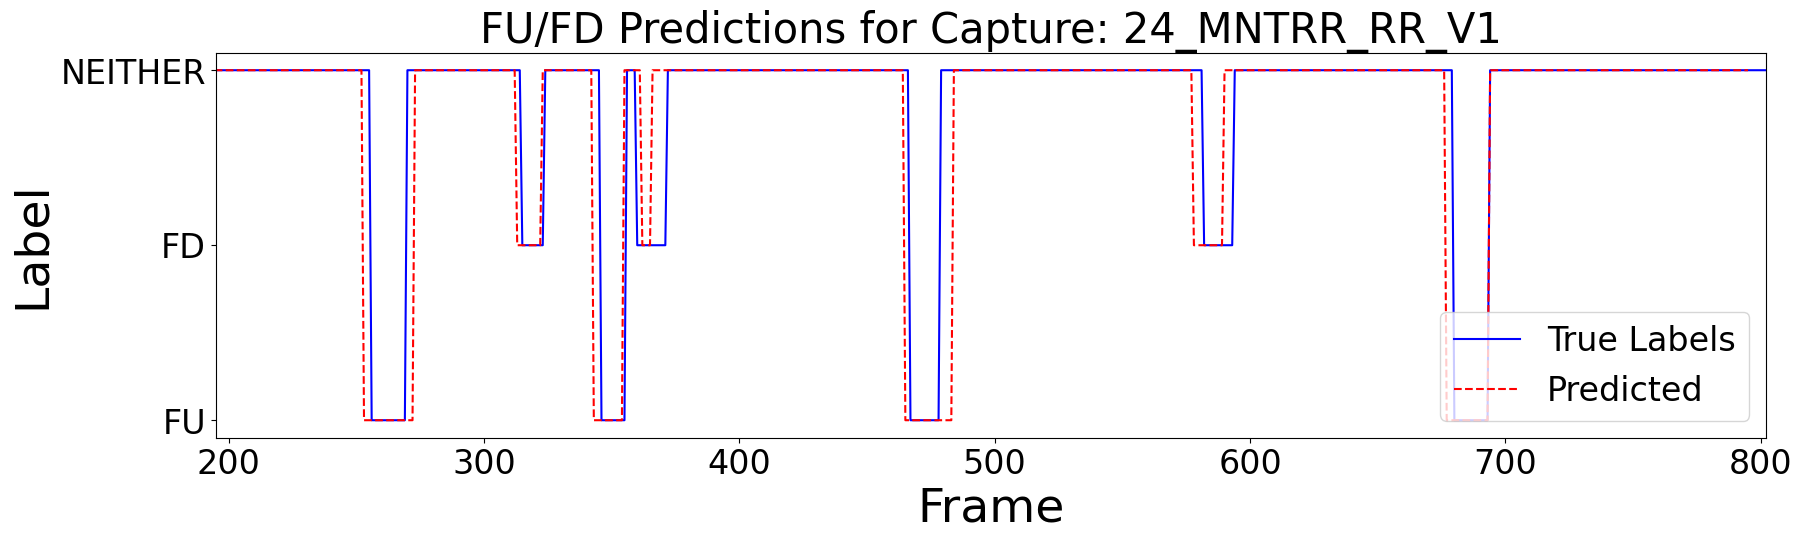

Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V1, channel: 2
[(256, 0), (315, 1), (346, 0), (360, 1), (467, 0), (582, 1), (680, 0)]
[[4 0 0]
 [0 3 0]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

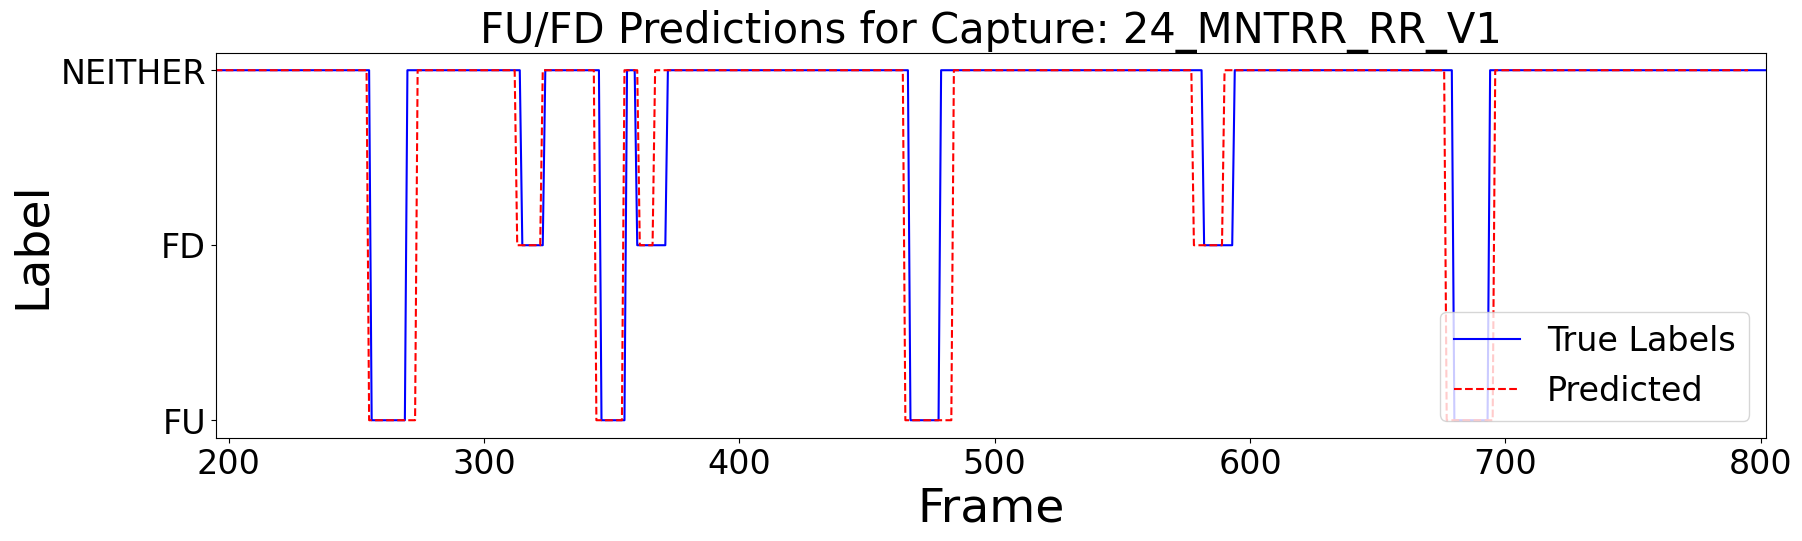

Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V1, channel: 3
[(256, 0), (315, 1), (346, 0), (360, 1), (467, 0), (582, 1), (680, 0)]
[[4 0 0]
 [0 2 1]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

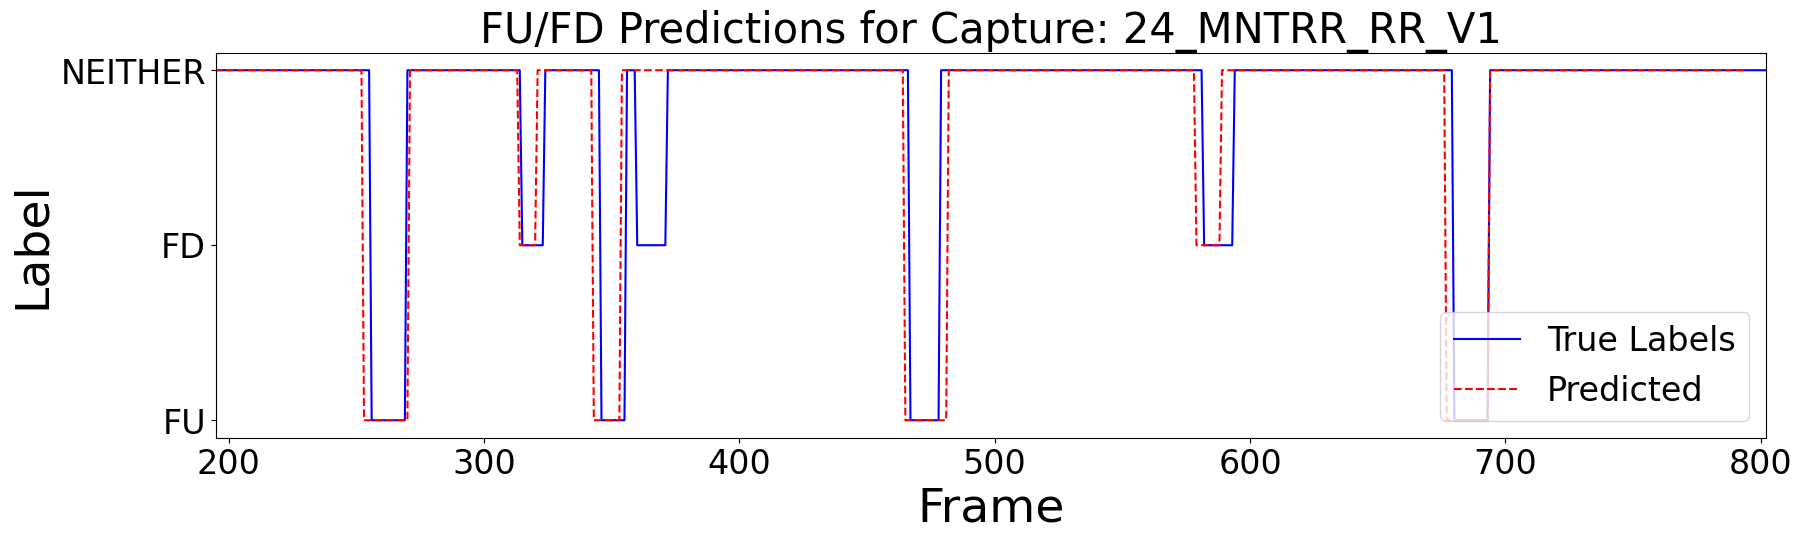

Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V1, channel: 4
[(256, 0), (315, 1), (346, 0), (360, 1), (467, 0), (582, 1), (680, 0)]
[[4 0 0]
 [0 2 1]
 [0 0 0]]


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

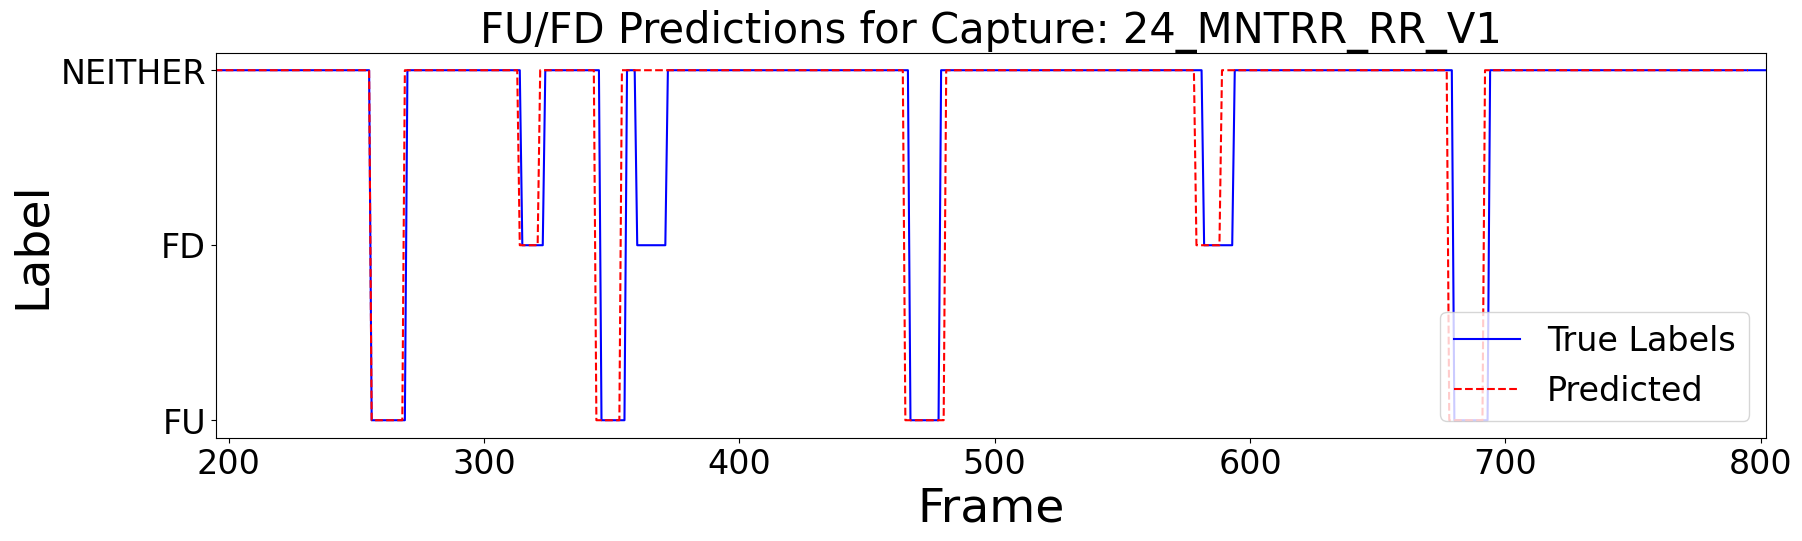

Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V2, channel: 1
[(264, 0), (368, 1), (473, 0), (580, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V2, channel: 2


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(264, 0), (368, 1), (473, 0), (580, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V2, channel: 3
[(264, 0), (368, 1), (473, 0), (580, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V2, channel: 4
[(264, 0), (368, 1), (473, 0), (580, 1), (684, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V3, channel: 1


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(261, 0), (376, 1), (470, 0), (584, 1), (679, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V3, channel: 2
[(261, 0), (376, 1), (470, 0), (584, 1), (679, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V3, channel: 3
[(261, 0), (376, 1), (470, 0), (584, 1), (679, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
Creating windows 51 windows for Radar Capture: 24_MNTRR_RR_V3, channel: 4


/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  window_data = torch.tensor(capture_data)[start:end]
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  lengths_tensor = torch.tensor(lengths, dtype=torch.long)
/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/RdmFullCapture.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

[(261, 0), (376, 1), (470, 0), (584, 1), (679, 0)]
[[3 0 0]
 [0 2 0]
 [0 0 0]]
[[217   0   1]
 [  0 143   3]
 [  6   4   0]]


In [11]:
print(len(test_dataset))

accumulated_conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

for i in range(len(test_dataset)):
    windows, labels, lengths, metadata, windows_ranges = test_dataset.create_windows_for_capture(index=i, overlap=90)
    # Assuming windows_ranges is a list of dictionaries with 'window_start_frame' and 'window_end_frame'
    windows_ranges_sorted = sorted(windows_ranges, key=lambda x: x['window_start_frame'])
    
    # Assuming 'windows' is a list or a batch of window tensors that need to be sorted according to windows_ranges_sorted
    # If 'windows' is a tensor of shape [N, C, H, W] where N is the number of windows, you might need to create a sorted tensor based on the sorted order of windows_ranges
    sorted_indexes = [windows_ranges.index(w_range) for w_range in windows_ranges_sorted]
    windows_sorted = [windows[idx] for idx in sorted_indexes]
    lengths_sorted = [lengths[idx] for idx in sorted_indexes]
    
    # Convert lists to tensors if necessary
    windows_tensor_sorted = torch.stack(windows_sorted)  # Assuming windows_sorted is a list of tensor windows
    lengths_tensor_sorted = torch.tensor(lengths_sorted, dtype=torch.long)

    # Now proceed with prediction using the sorted tensors
    prediction_windows = test_dataset.predict_on_windows(model, windows_tensor_sorted, lengths_tensor_sorted)

    # Assuming 'aggregate_predictions_sliding_windows' expects predictions in the sequence order
    full_predictions = test_dataset.aggregate_predictions_sliding_windows(prediction_windows, windows_ranges_sorted)
    
    # Find segments with more than 5 consecutive frame predictions
    segments = test_dataset.find_consecutive_segments(full_predictions)[1:]
    true_segments = test_dataset.find_consecutive_segments()
    
    print(true_segments)

    # Generate confusion matrix
    #conf_matrix = test_dataset.generate_confusion_matrix(segments)
    conf_matrix = test_dataset.generate_full_confusion_matrix(segments, true_segments, full_predictions)

       
    print(conf_matrix)

    # Add the current confusion matrix to the accumulated confusion matrix
    accumulated_conf_matrix += conf_matrix

    # For demonstration, plot the first one
    if i <= 100:
        if metadata['RADAR_capture'] == '24_MNTRR_RR_V1' or metadata['RADAR_capture'] == '18_MNTRL_RR_V3':
            test_dataset.plot_predictions_without_time(i, full_predictions, metadata['RADAR_capture'])
        
    else:
        break  # Remove this line if you want to plot for all captures

print(accumulated_conf_matrix)

In [12]:
# smoothing test 
import numpy as np
import torch

def test_model(model, test_loader, criterion, window_size=5):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient computation
        for data, labels, lengths, metadata in test_loader:
            data = data.float()  # Ensure data is float
            outputs = model(data, lengths)  # Pass both data and lengths to the model
            outputs_flat = outputs.view(-1, num_classes)  # Flatten output for loss calculation
            labels_flat = labels.view(-1)

            # Convert model outputs to probabilities using softmax
            probabilities = torch.softmax(outputs_flat, dim=1).cpu().numpy()

            # Smooth probabilities for each class
            smoothed_probabilities = np.apply_along_axis(
                lambda m: np.convolve(m, np.ones(window_size)/window_size, mode='same'), 
                axis=0, 
                arr=probabilities)

            # Select the class with the highest smoothed probability for each prediction
            smoothed_predictions = np.argmax(smoothed_probabilities, axis=1)

            # Update correct predictions count
            correct_predictions += (smoothed_predictions == labels_flat.cpu().numpy()).sum()
            total_predictions += labels_flat.size(0)

            # Continue with loss calculation (using original, unsmoothed predictions)
            loss = criterion(outputs_flat, labels_flat)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_predictions  # Calculate accuracy using total predictions
    print(f'Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')


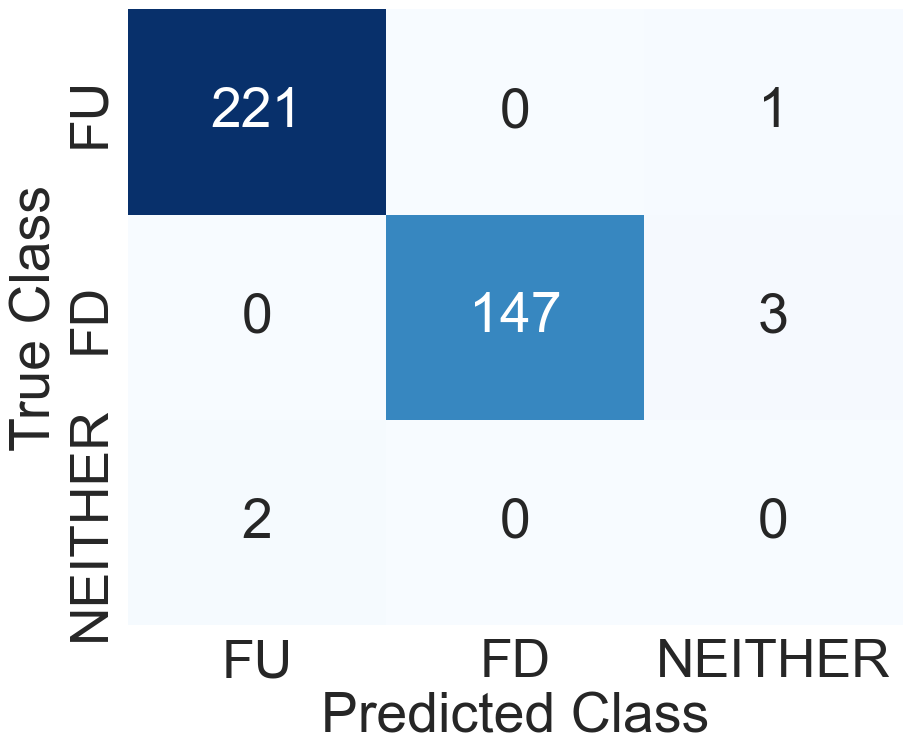

Accuracy: 0.98, Sensitivity GOUP: 0.99, Specificity GOUP: 0.99, Sensitivity DOWN: 0.99, Specificity DOWN: 1.00


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the confusion matrix
conf_matrix = np.array([[221,   0,   1],
                        [  0, 147,   3],
                        [  2,   0,   0]])

# Class names
class_names = ["FU", "FD", "NEITHER"]

# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

# Sensitivity for GOUP: (True Positive for GOUP) / (True Positive for GOUP + False Negative for GOUP)
sensitivity_goup = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[2, 0])

# Specificity for GOUP: (True Negative for GOUP) / (True Negative for GOUP + False Positive for GOUP)
specificity_goup = np.sum(np.delete(np.delete(conf_matrix, 0, axis=0), 0, axis=1)) / (np.sum(np.delete(np.delete(conf_matrix, 0, axis=0), 0, axis=1)) + conf_matrix[0, 1] + conf_matrix[0, 2])

# Sensitivity for DOWN: (True Positive for DOWN) / (True Positive for DOWN + False Negative for DOWN)
sensitivity_down = 147/(147+2)

# Specificity for DOWN: (True Negative for DOWN) / (True Negative for DOWN + False Positive for DOWN)
specificity_down = 222/(222)

# Adjusting font sizes
sns.set(font_scale=3.5)  # Adjust to make fonts larger, e.g., 1.5, 2.0, etc.

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 40},
            xticklabels=class_names, yticklabels=class_names)  # Use class names for tick labelsplt.title('Confusion Matrix', size=40)  # Adjust title size
plt.ylabel('True Class', size=40)  # Adjust y-label size
plt.xlabel('Predicted Class', size=40)  # Adjust x-label size
plt.show()

# Print accuracy and other metrics with larger font sizes if necessary
print(f"Accuracy: {accuracy:.2f}, Sensitivity GOUP: {sensitivity_goup:.2f}, Specificity GOUP: {specificity_goup:.2f}, Sensitivity DOWN: {sensitivity_down:.2f}, Specificity DOWN: {specificity_down:.2f}")
